<a href="https://colab.research.google.com/github/aqhareus/floorplan-stable-diffusion-AI54/blob/main/1_Dataset_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎯 Dataset Preprocessing: Background Removal + 0° Alignment (300 Iterations)

## Critical Fix + Strict Filtering! 🛠️

### Problems Solved:
1. ✅ **White background removed** (was confusing the model)
2. ✅ **Black rotation artifacts removed** (corner triangles)
3. ✅ **Content cropped and centered** (on black background)
4. ✅ **Aspect ratio preserved** (no distortion)
5. ✅ **STRICT FILTER: ≤0.5° (essentially 0°)**
6. ✅ **300 iterations (better convergence)**

### Process:
1. Rotate to align floorplan (up to 300 iterations)
2. Detect actual content boundaries
3. Crop to remove white space
4. Resize and center on black canvas
5. Filter: **Only keep samples ≤ 0.5°** (near-perfect)

**Memory efficient + Clean output + Strict quality!** ✨

---

In [ ]:
!pip install -q datasets opencv-python pillow matplotlib numpy tqdm huggingface-hub

In [ ]:
!pip install -q wandb
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import wandb
from datasets import load_dataset, load_from_disk, DatasetDict, Dataset
from huggingface_hub import login
from tqdm import tqdm
import warnings
import gc
import os
warnings.filterwarnings('ignore')

print("✅ Ready!")

✅ Ready!


In [ ]:
# Initialize Weights & Biases
wandb.login()

# Initialize a new run
wandb.init(
    project="AI54-Floorplan",
    name="dataset-alignment-0deg-300iter",
    config={
        "tolerance": 0.5,
        "max_iterations": 300,
        "batch_size": 100,
        "filter_threshold": 0.5,
        "dataset_size": 12000,
        "background_cleaning": True,
        "target_size": 512
    }
)

print("✅ W&B initialized!")
print(f"📊 Project: {wandb.run.project}")
print(f"🏃 Run: {wandb.run.name}")
print(f"🔗 URL: {wandb.run.url}")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


batch_1/kept,▁
batch_1/max_angle,▁
batch_1/mean_angle,▁
batch_1/processed,▁
batch_1/removed,▁
batch_1/retention_rate,▁
batch_10/kept,▁
batch_10/max_angle,▁
batch_10/mean_angle,▁
batch_10/processed,▁
+236,...


✅ W&B initialized!
📊 Project: AI54-Floorplan
🏃 Run: dataset-alignment-0deg-300iter
🔗 URL: https://wandb.ai/sofeasuhaimi-utbm/AI54-Floorplan/runs/0a0za64u


In [ ]:
ds = load_dataset("zimhe/pseudo-floor-plan-12k", split="train")
print(f"✅ Loaded {len(ds)} samples")

✅ Loaded 12000 samples


## 📐 Functions

In [ ]:
def clean_background(img, mask_type='footprint'):
    """
    Remove white background and rotation artifacts.
    Returns clean image with black background or cropped to content.
    """
    # Convert to numpy if PIL Image
    if hasattr(img, 'mode'):
        img = np.array(img)

    # Create binary mask of non-white areas
    if len(img.shape) == 3:
        # For color images: detect anything that's not pure white
        white_mask = np.all(img > 250, axis=-1)  # Pixels that are almost white
        content_mask = ~white_mask  # Invert to get content
    else:
        # For grayscale
        content_mask = img < 250

    # Find bounding box of content
    coords = np.column_stack(np.where(content_mask))
    if len(coords) == 0:
        return img  # No content found, return original

    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)

    # Add small padding
    padding = 5
    y_min = max(0, y_min - padding)
    x_min = max(0, x_min - padding)
    y_max = min(img.shape[0], y_max + padding)
    x_max = min(img.shape[1], x_max + padding)

    # Crop to bounding box
    cropped = img[y_min:y_max, x_min:x_max]

    # Resize back to 512x512 with black background
    h, w = cropped.shape[:2]

    # Calculate scaling to fit in 512x512 while maintaining aspect ratio
    scale = min(512 / h, 512 / w)
    new_h, new_w = int(h * scale), int(w * scale)

    # Resize cropped content
    if mask_type in ['footprint', 'colors']:  # Segmentation masks
        resized = cv2.resize(cropped, (new_w, new_h), interpolation=cv2.INTER_NEAREST)
    else:  # walls, plans
        resized = cv2.resize(cropped, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # Create 512x512 canvas with black background
    if len(img.shape) == 3:
        canvas = np.zeros((512, 512, img.shape[2]), dtype=img.dtype)
    else:
        canvas = np.zeros((512, 512), dtype=img.dtype)

    # Center the content on canvas
    y_offset = (512 - new_h) // 2
    x_offset = (512 - new_w) // 2
    canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized

    return canvas



In [ ]:
def measure_deviation_from_horizontal(mask):
    if len(mask.shape) == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return 0.0

    largest = max(contours, key=cv2.contourArea)
    if cv2.contourArea(largest) < 100:
        return 0.0

    rect = cv2.minAreaRect(largest)
    ((cx, cy), (w, h), angle) = rect

    if w >= h:
        deviation = angle
    else:
        deviation = angle + 90

    while deviation > 45:
        deviation -= 90
    while deviation < -45:
        deviation += 90

    return deviation

def rotate_to_horizontal_300(sample, tolerance=0.5, max_iters=300):
    try:
        fp = np.array(sample['footprints'])
        wa = np.array(sample['walls'])
        co = np.array(sample['colors'])
        pl = np.array(sample['plans'])

        # Store original for "before" visualization
        co_original = co.copy()  # Keep original colors for before/after comparison

        h, w = fp.shape[:2]
        center = (w//2, h//2)

        total_rotation = 0.0
        fp_work = fp.copy()

        # ✅ MEASURE INITIAL ANGLE - This was missing!
        initial_angle = measure_deviation_from_horizontal(fp_work)

        converged = False
        iterations_used = 0

        for iteration in range(max_iters):
            current_deviation = measure_deviation_from_horizontal(fp_work)

            if abs(current_deviation) < tolerance:
                converged = True
                iterations_used = iteration + 1
                break

            correction = -current_deviation
            total_rotation += correction

            M = cv2.getRotationMatrix2D(center, correction, 1.0)
            fp_work = cv2.warpAffine(fp_work, M, (w, h),
                                      flags=cv2.INTER_NEAREST, borderValue=0)

        if not converged:
            iterations_used = max_iters

        M_final = cv2.getRotationMatrix2D(center, total_rotation, 1.0)

        fp_rot = cv2.warpAffine(fp, M_final, (w, h), flags=cv2.INTER_NEAREST, borderValue=0)
        wa_rot = cv2.warpAffine(wa, M_final, (w, h), flags=cv2.INTER_LINEAR, borderValue=0)
        co_rot = cv2.warpAffine(co, M_final, (w, h), flags=cv2.INTER_NEAREST, borderValue=0)
        pl_rot = cv2.warpAffine(pl, M_final, (w, h), flags=cv2.INTER_LINEAR, borderValue=0)

        fp_f = clean_background(fp_rot, mask_type='footprint')
        wa_f = clean_background(wa_rot, mask_type='walls')
        co_f = clean_background(co_rot, mask_type='colors')
        pl_f = clean_background(pl_rot, mask_type='plans')

        final_angle = measure_deviation_from_horizontal(fp_f)

        # ✅ RETURN ALL REQUIRED FIELDS
        return {
            'footprints': Image.fromarray(fp_f),
            'walls': Image.fromarray(wa_f),
            'colors': Image.fromarray(co_f),
            'plans': Image.fromarray(pl_f),
            'final_angle': final_angle,
            'initial_angle': initial_angle,            #  INCLUDED
            'total_rotation': total_rotation,          #  INCLUDED
            'iterations_used': iterations_used,        #  INCLUDED
            'converged': converged,                    #  INCLUDED
            'indices': sample['indices'],
            'captions': sample['captions'],
            'before_colors': Image.fromarray(co_original),  #  INCLUDED
            'after_colors': Image.fromarray(co_f)           #  INCLUDED
        }
    except Exception as e:
        print(f"Error processing sample: {e}")
        return None

print("✅ Functions ready")

✅ Functions ready


## 🧪 Visual Test on Sample #20 (Debug)


Testing Sample #20 (was problematic at 31.4°)

BEFORE rotation: -17.87°
AFTER rotation:  -0.35°

✅ SUCCESS! Within ±0.5°


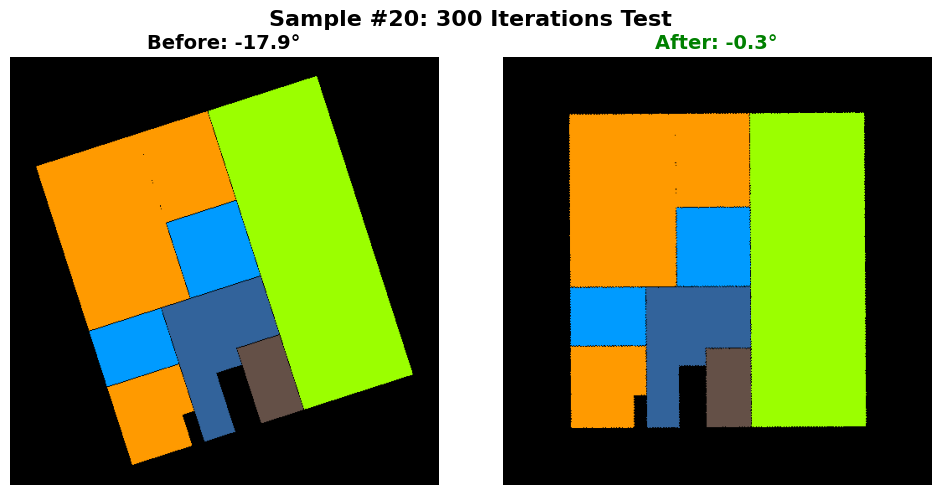

In [ ]:
# Test on problematic sample #20 with visual output
test_idx = 20
sample = ds[test_idx]

print(f"\n{'='*65}")
print(f"Testing Sample #{test_idx} (was problematic at 31.4°)")
print(f"{'='*65}\n")

# Measure before
fp_before = np.array(sample['footprints'])
angle_before = measure_deviation_from_horizontal(fp_before)

print(f"BEFORE rotation: {angle_before:.2f}°")

# Process
result = rotate_to_horizontal_300(sample)

if result:
    print(f"AFTER rotation:  {result['final_angle']:.2f}°\n")

    if abs(result['final_angle']) < 0.5:
        print(f"✅ SUCCESS! Within ±0.5°")
    else:
        print(f"⚠️  Still at {result['final_angle']:.2f}°")

    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(sample['colors'])
    axes[0].set_title(f'Before: {angle_before:.1f}°', fontsize=14, fontweight='bold')
    axes[0].axis('off')

    axes[1].imshow(result['colors'])
    axes[1].set_title(f'After: {result["final_angle"]:.1f}°',
                      fontsize=14, color='green', fontweight='bold')
    axes[1].axis('off')

    plt.suptitle(f'Sample #{test_idx}: 300 Iterations Test', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

print(f"\n{'='*65}")

## 🎨 Visual Test on Multiple Samples

Testing Multiple Samples:

Sample | Before    | After     | Status
#  0   |   -37.14° |     0.00° | ✅
# 10   |   -17.14° |    -0.53° | ⚠️
# 20   |   -17.87° |    -0.35° | ✅
# 40   |   -40.47° |    13.82° | ⚠️
# 60   |   -28.30° |    -1.18° | ⚠️
# 80   |    28.19° |     0.00° | ✅
#100   |     2.87° |     0.19° | ✅


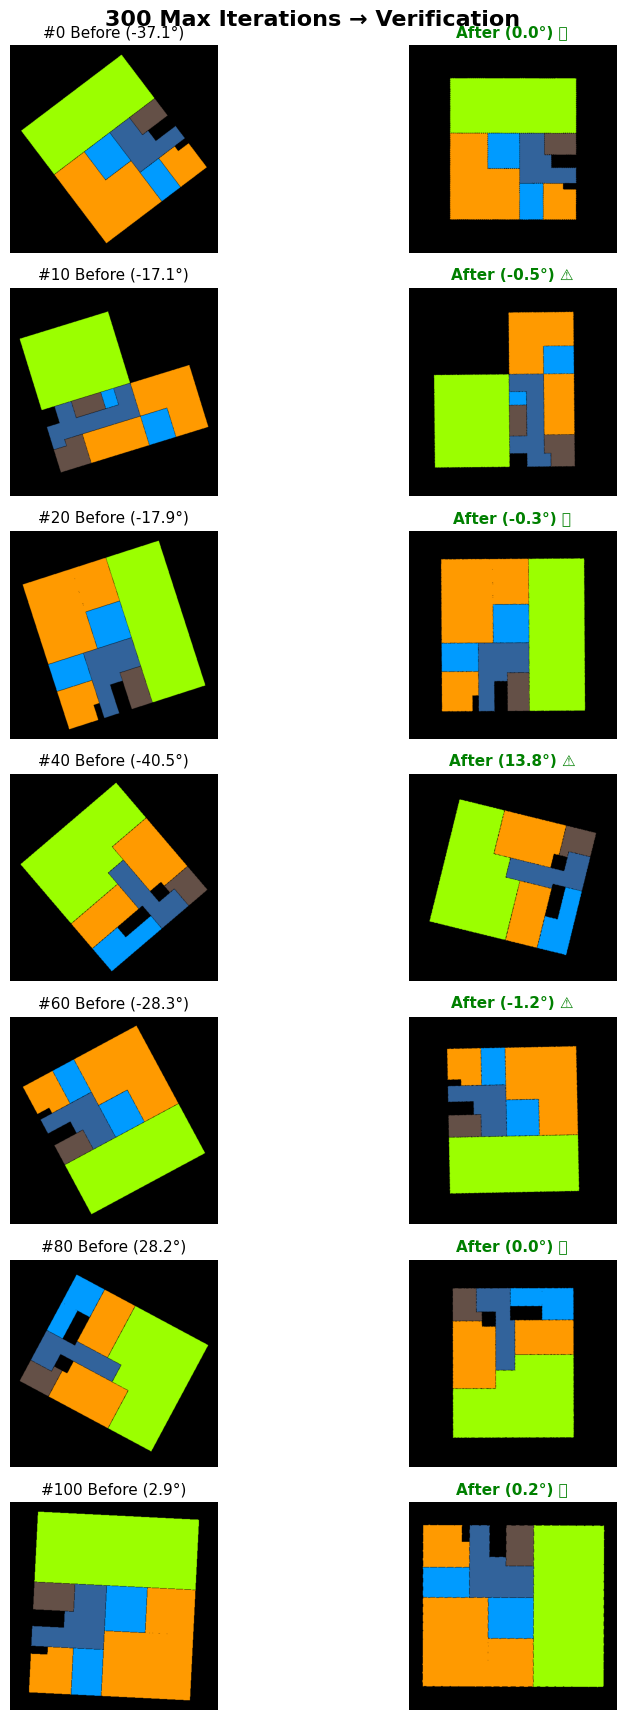

In [ ]:
# Test on 7 samples with visual verification
test_indices = [0, 10, 20, 40, 60, 80, 100]

fig, axes = plt.subplots(len(test_indices), 2, figsize=(10, len(test_indices)*2.5))

print("Testing Multiple Samples:\n")
print("Sample | Before    | After     | Status")
print("="*55)

for i, idx in enumerate(test_indices):
    sample = ds[idx]

    # Measure before
    fp_before = np.array(sample['footprints'])
    angle_before = measure_deviation_from_horizontal(fp_before)

    # Process
    result = rotate_to_horizontal_300(sample)

    if result:
        status = "✅" if abs(result['final_angle']) < 0.5 else "⚠️"

        print(f"#{idx:3d}   | {angle_before:8.2f}° | {result['final_angle']:8.2f}° | {status}")

        # Before
        axes[i,0].imshow(sample['colors'])
        axes[i,0].set_title(f"#{idx} Before ({angle_before:.1f}°)", fontsize=11)
        axes[i,0].axis('off')

        # After
        axes[i,1].imshow(result['colors'])
        axes[i,1].set_title(f"After ({result['final_angle']:.1f}°) {status}",
                            fontsize=11, color='green', fontweight='bold')
        axes[i,1].axis('off')

plt.suptitle('300 Max Iterations → Verification', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('verification_results.png', dpi=200, bbox_inches='tight')
plt.show()

## 🚀 BATCH PROCESSING (Memory Efficient!)

In [ ]:
# Configuration
BATCH_SIZE = 100  # Process 100 at a time
OUTPUT_DIR = "./processed_batches"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Processing in batches of {BATCH_SIZE}...\n")
print(f"Total batches: {len(ds) // BATCH_SIZE + 1}")
print(f"Output: {OUTPUT_DIR}/\n")

batch_stats = []
total_processed = 0
total_kept = 0

# Process in batches
for batch_idx in range(0, len(ds), BATCH_SIZE):
    batch_end = min(batch_idx + BATCH_SIZE, len(ds))
    batch_num = batch_idx // BATCH_SIZE + 1

    print(f"\n{'='*70}")
    print(f"BATCH {batch_num}: Processing samples {batch_idx} to {batch_end-1}")
    print(f"{'='*70}")

    # Process this batch
    batch_data = {
        'footprints': [],
        'walls': [],
        'colors': [],
        'plans': [],
        'indices': [],
        'captions': [],
        'final_angle': []
    }

    for i in tqdm(range(batch_idx, batch_end), desc=f"Batch {batch_num}"):
        result = rotate_to_horizontal_300(ds[i])

        if result is not None:
            # FILTER: STRICT - Only keep if ≤ 0.5° (essentially 0°)
            if abs(result['final_angle']) <= 0.5:
                # Log first 3 samples of each batch to W&B
                if len(batch_data['footprints']) < 3:
                    wandb.log({
                        f"batch_{batch_num}_sample_{len(batch_data['footprints'])}_before": wandb.Image(
                            result['before_colors'],
                            caption=f"Before: {result['initial_angle']:.2f}°"
                        ),
                        f"batch_{batch_num}_sample_{len(batch_data['footprints'])}_after": wandb.Image(
                            result['after_colors'],
                            caption=f"After: {result['final_angle']:.2f}° ({result['iterations_used']} iters)"
                        ),
                        f"batch_{batch_num}_sample_{len(batch_data['footprints'])}_rotation": result['total_rotation'],
                        f"batch_{batch_num}_sample_{len(batch_data['footprints'])}_iterations": result['iterations_used'],
                    })

                batch_data['footprints'].append(result['footprints'])
                batch_data['walls'].append(result['walls'])
                batch_data['colors'].append(result['colors'])
                batch_data['plans'].append(result['plans'])
                batch_data['indices'].append(result['indices'])
                batch_data['captions'].append(result['captions'])
                batch_data['final_angle'].append(result['final_angle'])

    # Stats for this batch
    batch_processed = batch_end - batch_idx
    batch_kept = len(batch_data['footprints'])
    total_processed += batch_processed
    total_kept += batch_kept

    batch_finals = np.abs(batch_data['final_angle'])

    print(f"\n📊 Batch {batch_num} Stats:")
    print(f"   Processed: {batch_processed}")
    print(f"   Kept:      {batch_kept} ({100*batch_kept/batch_processed:.1f}%)")
    print(f"   Removed:   {batch_processed - batch_kept}")
    if len(batch_finals) > 0:
        print(f"   Mean angle: {np.mean(batch_finals):.2f}°")
        print(f"   Max angle:  {np.max(batch_finals):.2f}°")

    # Save batch to disk (WITHOUT final_angle metadata)
    batch_data_clean = {
        'footprints': batch_data['footprints'],
        'walls': batch_data['walls'],
        'colors': batch_data['colors'],
        'plans': batch_data['plans'],
        'indices': batch_data['indices'],
        'captions': batch_data['captions']
    }

    batch_dataset = Dataset.from_dict(batch_data_clean)
    batch_path = f"{OUTPUT_DIR}/batch_{batch_num:03d}"
    batch_dataset.save_to_disk(batch_path)

    print(f"   Saved: {batch_path}")

    # Log batch statistics to W&B
    wandb.log({
        f"batch_{batch_num}/processed": batch_processed,
        f"batch_{batch_num}/kept": batch_kept,
        f"batch_{batch_num}/retention_rate": 100 * batch_kept / batch_processed,
        f"batch_{batch_num}/removed": batch_processed - batch_kept,
        f"batch_{batch_num}/mean_angle": np.mean(batch_finals) if len(batch_finals) > 0 else 0,
        f"batch_{batch_num}/max_angle": np.max(batch_finals) if len(batch_finals) > 0 else 0,
    })


    # Store stats
    batch_stats.append({
        'batch': batch_num,
        'processed': batch_processed,
        'kept': batch_kept,
        'mean_angle': np.mean(batch_finals) if len(batch_finals) > 0 else 0,
        'max_angle': np.max(batch_finals) if len(batch_finals) > 0 else 0
    })

    # CRITICAL: Clear memory!
    del batch_data
    del batch_dataset
    gc.collect()

print(f"\n{'='*70}")
print(f"COMPLETE!")
print(f"{'='*70}")
print(f"\n📊 OVERALL Stats:")
print(f"   Total processed: {total_processed}")
print(f"   Total kept:      {total_kept} ({100*total_kept/total_processed:.1f}%)")
print(f"   Total removed:   {total_processed - total_kept}")
print(f"\n✅ All batches saved to: {OUTPUT_DIR}/")

# Log final summary to W&B
wandb.log({
    "final/total_processed": total_processed,
    "final/total_kept": total_kept,
    "final/total_removed": total_processed - total_kept,
    "final/retention_rate": 100 * total_kept / total_processed,
})

# Create summary table
summary_table = wandb.Table(
    columns=["Batch", "Processed", "Kept", "Retention %", "Mean Angle", "Max Angle"],
    data=[[s["batch"], s["processed"], s["kept"],
           100*s["kept"]/s["processed"], s["mean_angle"], s["max_angle"]]
          for s in batch_stats]
)
wandb.log({"batch_summary_table": summary_table})

print(f"\n📊 Results logged to W&B: {wandb.run.url}")

Processing in batches of 100...

Total batches: 121
Output: ./processed_batches/


BATCH 1: Processing samples 0 to 99


Batch 1: 100%|██████████| 100/100 [00:42<00:00,  2.37it/s]



📊 Batch 1 Stats:
   Processed: 100
   Kept:      63 (63.0%)
   Removed:   37
   Mean angle: 0.16°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/63 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_001

BATCH 2: Processing samples 100 to 199


Batch 2: 100%|██████████| 100/100 [00:38<00:00,  2.58it/s]



📊 Batch 2 Stats:
   Processed: 100
   Kept:      66 (66.0%)
   Removed:   34
   Mean angle: 0.18°
   Max angle:  0.50°


Saving the dataset (0/1 shards):   0%|          | 0/66 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_002

BATCH 3: Processing samples 200 to 299


Batch 3: 100%|██████████| 100/100 [00:42<00:00,  2.35it/s]



📊 Batch 3 Stats:
   Processed: 100
   Kept:      57 (57.0%)
   Removed:   43
   Mean angle: 0.18°
   Max angle:  0.48°


Saving the dataset (0/1 shards):   0%|          | 0/57 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_003

BATCH 4: Processing samples 300 to 399


Batch 4: 100%|██████████| 100/100 [00:42<00:00,  2.34it/s]



📊 Batch 4 Stats:
   Processed: 100
   Kept:      58 (58.0%)
   Removed:   42
   Mean angle: 0.19°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/58 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_004

BATCH 5: Processing samples 400 to 499


Batch 5: 100%|██████████| 100/100 [00:40<00:00,  2.46it/s]



📊 Batch 5 Stats:
   Processed: 100
   Kept:      65 (65.0%)
   Removed:   35
   Mean angle: 0.20°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/65 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_005

BATCH 6: Processing samples 500 to 599


Batch 6: 100%|██████████| 100/100 [00:39<00:00,  2.56it/s]



📊 Batch 6 Stats:
   Processed: 100
   Kept:      66 (66.0%)
   Removed:   34
   Mean angle: 0.21°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/66 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_006

BATCH 7: Processing samples 600 to 699


Batch 7: 100%|██████████| 100/100 [00:38<00:00,  2.58it/s]



📊 Batch 7 Stats:
   Processed: 100
   Kept:      69 (69.0%)
   Removed:   31
   Mean angle: 0.20°
   Max angle:  0.50°


Saving the dataset (0/1 shards):   0%|          | 0/69 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_007

BATCH 8: Processing samples 700 to 799


Batch 8: 100%|██████████| 100/100 [00:43<00:00,  2.27it/s]



📊 Batch 8 Stats:
   Processed: 100
   Kept:      58 (58.0%)
   Removed:   42
   Mean angle: 0.25°
   Max angle:  0.50°


Saving the dataset (0/1 shards):   0%|          | 0/58 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_008

BATCH 9: Processing samples 800 to 899


Batch 9: 100%|██████████| 100/100 [00:44<00:00,  2.24it/s]



📊 Batch 9 Stats:
   Processed: 100
   Kept:      64 (64.0%)
   Removed:   36
   Mean angle: 0.19°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/64 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_009

BATCH 10: Processing samples 900 to 999


Batch 10: 100%|██████████| 100/100 [00:38<00:00,  2.61it/s]



📊 Batch 10 Stats:
   Processed: 100
   Kept:      62 (62.0%)
   Removed:   38
   Mean angle: 0.18°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/62 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_010

BATCH 11: Processing samples 1000 to 1099


Batch 11: 100%|██████████| 100/100 [00:38<00:00,  2.57it/s]



📊 Batch 11 Stats:
   Processed: 100
   Kept:      58 (58.0%)
   Removed:   42
   Mean angle: 0.23°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/58 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_011

BATCH 12: Processing samples 1100 to 1199


Batch 12: 100%|██████████| 100/100 [00:39<00:00,  2.56it/s]



📊 Batch 12 Stats:
   Processed: 100
   Kept:      63 (63.0%)
   Removed:   37
   Mean angle: 0.21°
   Max angle:  0.48°


Saving the dataset (0/1 shards):   0%|          | 0/63 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_012

BATCH 13: Processing samples 1200 to 1299


Batch 13: 100%|██████████| 100/100 [00:38<00:00,  2.60it/s]



📊 Batch 13 Stats:
   Processed: 100
   Kept:      64 (64.0%)
   Removed:   36
   Mean angle: 0.23°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/64 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_013

BATCH 14: Processing samples 1300 to 1399


Batch 14: 100%|██████████| 100/100 [00:40<00:00,  2.47it/s]



📊 Batch 14 Stats:
   Processed: 100
   Kept:      63 (63.0%)
   Removed:   37
   Mean angle: 0.21°
   Max angle:  0.48°


Saving the dataset (0/1 shards):   0%|          | 0/63 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_014

BATCH 15: Processing samples 1400 to 1499


Batch 15: 100%|██████████| 100/100 [00:37<00:00,  2.67it/s]



📊 Batch 15 Stats:
   Processed: 100
   Kept:      68 (68.0%)
   Removed:   32
   Mean angle: 0.17°
   Max angle:  0.48°


Saving the dataset (0/1 shards):   0%|          | 0/68 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_015

BATCH 16: Processing samples 1500 to 1599


Batch 16: 100%|██████████| 100/100 [00:35<00:00,  2.83it/s]



📊 Batch 16 Stats:
   Processed: 100
   Kept:      59 (59.0%)
   Removed:   41
   Mean angle: 0.20°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/59 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_016

BATCH 17: Processing samples 1600 to 1699


Batch 17: 100%|██████████| 100/100 [00:42<00:00,  2.33it/s]



📊 Batch 17 Stats:
   Processed: 100
   Kept:      54 (54.0%)
   Removed:   46
   Mean angle: 0.24°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/54 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_017

BATCH 18: Processing samples 1700 to 1799


Batch 18: 100%|██████████| 100/100 [00:39<00:00,  2.53it/s]



📊 Batch 18 Stats:
   Processed: 100
   Kept:      60 (60.0%)
   Removed:   40
   Mean angle: 0.18°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/60 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_018

BATCH 19: Processing samples 1800 to 1899


Batch 19: 100%|██████████| 100/100 [00:35<00:00,  2.78it/s]



📊 Batch 19 Stats:
   Processed: 100
   Kept:      63 (63.0%)
   Removed:   37
   Mean angle: 0.19°
   Max angle:  0.48°


Saving the dataset (0/1 shards):   0%|          | 0/63 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_019

BATCH 20: Processing samples 1900 to 1999


Batch 20: 100%|██████████| 100/100 [00:42<00:00,  2.36it/s]



📊 Batch 20 Stats:
   Processed: 100
   Kept:      55 (55.0%)
   Removed:   45
   Mean angle: 0.17°
   Max angle:  0.50°


Saving the dataset (0/1 shards):   0%|          | 0/55 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_020

BATCH 21: Processing samples 2000 to 2099


Batch 21: 100%|██████████| 100/100 [00:41<00:00,  2.41it/s]



📊 Batch 21 Stats:
   Processed: 100
   Kept:      60 (60.0%)
   Removed:   40
   Mean angle: 0.19°
   Max angle:  0.50°


Saving the dataset (0/1 shards):   0%|          | 0/60 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_021

BATCH 22: Processing samples 2100 to 2199


Batch 22: 100%|██████████| 100/100 [00:42<00:00,  2.35it/s]



📊 Batch 22 Stats:
   Processed: 100
   Kept:      65 (65.0%)
   Removed:   35
   Mean angle: 0.21°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/65 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_022

BATCH 23: Processing samples 2200 to 2299


Batch 23: 100%|██████████| 100/100 [00:40<00:00,  2.49it/s]



📊 Batch 23 Stats:
   Processed: 100
   Kept:      58 (58.0%)
   Removed:   42
   Mean angle: 0.18°
   Max angle:  0.48°


Saving the dataset (0/1 shards):   0%|          | 0/58 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_023

BATCH 24: Processing samples 2300 to 2399


Batch 24: 100%|██████████| 100/100 [00:40<00:00,  2.46it/s]



📊 Batch 24 Stats:
   Processed: 100
   Kept:      64 (64.0%)
   Removed:   36
   Mean angle: 0.18°
   Max angle:  0.50°


Saving the dataset (0/1 shards):   0%|          | 0/64 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_024

BATCH 25: Processing samples 2400 to 2499


Batch 25: 100%|██████████| 100/100 [00:35<00:00,  2.83it/s]



📊 Batch 25 Stats:
   Processed: 100
   Kept:      64 (64.0%)
   Removed:   36
   Mean angle: 0.17°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/64 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_025

BATCH 26: Processing samples 2500 to 2599


Batch 26: 100%|██████████| 100/100 [00:39<00:00,  2.56it/s]



📊 Batch 26 Stats:
   Processed: 100
   Kept:      62 (62.0%)
   Removed:   38
   Mean angle: 0.20°
   Max angle:  0.50°


Saving the dataset (0/1 shards):   0%|          | 0/62 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_026

BATCH 27: Processing samples 2600 to 2699


Batch 27: 100%|██████████| 100/100 [00:38<00:00,  2.60it/s]



📊 Batch 27 Stats:
   Processed: 100
   Kept:      64 (64.0%)
   Removed:   36
   Mean angle: 0.19°
   Max angle:  0.47°


Saving the dataset (0/1 shards):   0%|          | 0/64 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_027

BATCH 28: Processing samples 2700 to 2799


Batch 28: 100%|██████████| 100/100 [00:37<00:00,  2.68it/s]



📊 Batch 28 Stats:
   Processed: 100
   Kept:      71 (71.0%)
   Removed:   29
   Mean angle: 0.21°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/71 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_028

BATCH 29: Processing samples 2800 to 2899


Batch 29: 100%|██████████| 100/100 [00:41<00:00,  2.43it/s]



📊 Batch 29 Stats:
   Processed: 100
   Kept:      64 (64.0%)
   Removed:   36
   Mean angle: 0.18°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/64 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_029

BATCH 30: Processing samples 2900 to 2999


Batch 30: 100%|██████████| 100/100 [00:42<00:00,  2.38it/s]



📊 Batch 30 Stats:
   Processed: 100
   Kept:      65 (65.0%)
   Removed:   35
   Mean angle: 0.18°
   Max angle:  0.50°


Saving the dataset (0/1 shards):   0%|          | 0/65 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_030

BATCH 31: Processing samples 3000 to 3099


Batch 31: 100%|██████████| 100/100 [00:45<00:00,  2.17it/s]



📊 Batch 31 Stats:
   Processed: 100
   Kept:      61 (61.0%)
   Removed:   39
   Mean angle: 0.16°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/61 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_031

BATCH 32: Processing samples 3100 to 3199


Batch 32: 100%|██████████| 100/100 [00:44<00:00,  2.23it/s]



📊 Batch 32 Stats:
   Processed: 100
   Kept:      59 (59.0%)
   Removed:   41
   Mean angle: 0.23°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/59 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_032

BATCH 33: Processing samples 3200 to 3299


Batch 33: 100%|██████████| 100/100 [00:43<00:00,  2.31it/s]



📊 Batch 33 Stats:
   Processed: 100
   Kept:      55 (55.0%)
   Removed:   45
   Mean angle: 0.18°
   Max angle:  0.50°


Saving the dataset (0/1 shards):   0%|          | 0/55 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_033

BATCH 34: Processing samples 3300 to 3399


Batch 34: 100%|██████████| 100/100 [00:37<00:00,  2.70it/s]



📊 Batch 34 Stats:
   Processed: 100
   Kept:      62 (62.0%)
   Removed:   38
   Mean angle: 0.23°
   Max angle:  0.50°


Saving the dataset (0/1 shards):   0%|          | 0/62 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_034

BATCH 35: Processing samples 3400 to 3499


Batch 35: 100%|██████████| 100/100 [00:39<00:00,  2.55it/s]



📊 Batch 35 Stats:
   Processed: 100
   Kept:      55 (55.0%)
   Removed:   45
   Mean angle: 0.22°
   Max angle:  0.50°


Saving the dataset (0/1 shards):   0%|          | 0/55 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_035

BATCH 36: Processing samples 3500 to 3599


Batch 36: 100%|██████████| 100/100 [00:39<00:00,  2.52it/s]



📊 Batch 36 Stats:
   Processed: 100
   Kept:      69 (69.0%)
   Removed:   31
   Mean angle: 0.21°
   Max angle:  0.50°


Saving the dataset (0/1 shards):   0%|          | 0/69 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_036

BATCH 37: Processing samples 3600 to 3699


Batch 37: 100%|██████████| 100/100 [00:37<00:00,  2.66it/s]



📊 Batch 37 Stats:
   Processed: 100
   Kept:      61 (61.0%)
   Removed:   39
   Mean angle: 0.19°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/61 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_037

BATCH 38: Processing samples 3700 to 3799


Batch 38: 100%|██████████| 100/100 [00:37<00:00,  2.63it/s]



📊 Batch 38 Stats:
   Processed: 100
   Kept:      58 (58.0%)
   Removed:   42
   Mean angle: 0.17°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/58 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_038

BATCH 39: Processing samples 3800 to 3899


Batch 39: 100%|██████████| 100/100 [00:39<00:00,  2.51it/s]



📊 Batch 39 Stats:
   Processed: 100
   Kept:      63 (63.0%)
   Removed:   37
   Mean angle: 0.20°
   Max angle:  0.47°


Saving the dataset (0/1 shards):   0%|          | 0/63 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_039

BATCH 40: Processing samples 3900 to 3999


Batch 40: 100%|██████████| 100/100 [00:38<00:00,  2.63it/s]



📊 Batch 40 Stats:
   Processed: 100
   Kept:      67 (67.0%)
   Removed:   33
   Mean angle: 0.19°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/67 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_040

BATCH 41: Processing samples 4000 to 4099


Batch 41: 100%|██████████| 100/100 [00:40<00:00,  2.44it/s]



📊 Batch 41 Stats:
   Processed: 100
   Kept:      64 (64.0%)
   Removed:   36
   Mean angle: 0.21°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/64 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_041

BATCH 42: Processing samples 4100 to 4199


Batch 42: 100%|██████████| 100/100 [00:40<00:00,  2.46it/s]



📊 Batch 42 Stats:
   Processed: 100
   Kept:      63 (63.0%)
   Removed:   37
   Mean angle: 0.17°
   Max angle:  0.47°


Saving the dataset (0/1 shards):   0%|          | 0/63 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_042

BATCH 43: Processing samples 4200 to 4299


Batch 43: 100%|██████████| 100/100 [00:42<00:00,  2.33it/s]



📊 Batch 43 Stats:
   Processed: 100
   Kept:      58 (58.0%)
   Removed:   42
   Mean angle: 0.20°
   Max angle:  0.50°


Saving the dataset (0/1 shards):   0%|          | 0/58 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_043

BATCH 44: Processing samples 4300 to 4399


Batch 44: 100%|██████████| 100/100 [00:40<00:00,  2.48it/s]



📊 Batch 44 Stats:
   Processed: 100
   Kept:      64 (64.0%)
   Removed:   36
   Mean angle: 0.19°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/64 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_044

BATCH 45: Processing samples 4400 to 4499


Batch 45: 100%|██████████| 100/100 [00:38<00:00,  2.59it/s]



📊 Batch 45 Stats:
   Processed: 100
   Kept:      65 (65.0%)
   Removed:   35
   Mean angle: 0.22°
   Max angle:  0.48°


Saving the dataset (0/1 shards):   0%|          | 0/65 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_045

BATCH 46: Processing samples 4500 to 4599


Batch 46: 100%|██████████| 100/100 [00:41<00:00,  2.39it/s]



📊 Batch 46 Stats:
   Processed: 100
   Kept:      57 (57.0%)
   Removed:   43
   Mean angle: 0.17°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/57 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_046

BATCH 47: Processing samples 4600 to 4699


Batch 47: 100%|██████████| 100/100 [00:39<00:00,  2.55it/s]



📊 Batch 47 Stats:
   Processed: 100
   Kept:      55 (55.0%)
   Removed:   45
   Mean angle: 0.21°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/55 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_047

BATCH 48: Processing samples 4700 to 4799


Batch 48: 100%|██████████| 100/100 [00:37<00:00,  2.68it/s]



📊 Batch 48 Stats:
   Processed: 100
   Kept:      67 (67.0%)
   Removed:   33
   Mean angle: 0.20°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/67 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_048

BATCH 49: Processing samples 4800 to 4899


Batch 49: 100%|██████████| 100/100 [00:40<00:00,  2.47it/s]



📊 Batch 49 Stats:
   Processed: 100
   Kept:      54 (54.0%)
   Removed:   46
   Mean angle: 0.18°
   Max angle:  0.50°


Saving the dataset (0/1 shards):   0%|          | 0/54 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_049

BATCH 50: Processing samples 4900 to 4999


Batch 50: 100%|██████████| 100/100 [00:36<00:00,  2.72it/s]



📊 Batch 50 Stats:
   Processed: 100
   Kept:      58 (58.0%)
   Removed:   42
   Mean angle: 0.19°
   Max angle:  0.50°


Saving the dataset (0/1 shards):   0%|          | 0/58 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_050

BATCH 51: Processing samples 5000 to 5099


Batch 51: 100%|██████████| 100/100 [00:40<00:00,  2.45it/s]



📊 Batch 51 Stats:
   Processed: 100
   Kept:      60 (60.0%)
   Removed:   40
   Mean angle: 0.22°
   Max angle:  0.48°


Saving the dataset (0/1 shards):   0%|          | 0/60 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_051

BATCH 52: Processing samples 5100 to 5199


Batch 52: 100%|██████████| 100/100 [00:41<00:00,  2.42it/s]



📊 Batch 52 Stats:
   Processed: 100
   Kept:      60 (60.0%)
   Removed:   40
   Mean angle: 0.17°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/60 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_052

BATCH 53: Processing samples 5200 to 5299


Batch 53: 100%|██████████| 100/100 [00:40<00:00,  2.47it/s]



📊 Batch 53 Stats:
   Processed: 100
   Kept:      62 (62.0%)
   Removed:   38
   Mean angle: 0.21°
   Max angle:  0.48°


Saving the dataset (0/1 shards):   0%|          | 0/62 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_053

BATCH 54: Processing samples 5300 to 5399


Batch 54: 100%|██████████| 100/100 [00:36<00:00,  2.71it/s]



📊 Batch 54 Stats:
   Processed: 100
   Kept:      62 (62.0%)
   Removed:   38
   Mean angle: 0.20°
   Max angle:  0.48°


Saving the dataset (0/1 shards):   0%|          | 0/62 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_054

BATCH 55: Processing samples 5400 to 5499


Batch 55: 100%|██████████| 100/100 [00:39<00:00,  2.52it/s]



📊 Batch 55 Stats:
   Processed: 100
   Kept:      65 (65.0%)
   Removed:   35
   Mean angle: 0.21°
   Max angle:  0.50°


Saving the dataset (0/1 shards):   0%|          | 0/65 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_055

BATCH 56: Processing samples 5500 to 5599


Batch 56: 100%|██████████| 100/100 [00:40<00:00,  2.47it/s]



📊 Batch 56 Stats:
   Processed: 100
   Kept:      58 (58.0%)
   Removed:   42
   Mean angle: 0.21°
   Max angle:  0.50°


Saving the dataset (0/1 shards):   0%|          | 0/58 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_056

BATCH 57: Processing samples 5600 to 5699


Batch 57: 100%|██████████| 100/100 [00:41<00:00,  2.40it/s]



📊 Batch 57 Stats:
   Processed: 100
   Kept:      61 (61.0%)
   Removed:   39
   Mean angle: 0.20°
   Max angle:  0.47°


Saving the dataset (0/1 shards):   0%|          | 0/61 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_057

BATCH 58: Processing samples 5700 to 5799


Batch 58: 100%|██████████| 100/100 [00:38<00:00,  2.60it/s]



📊 Batch 58 Stats:
   Processed: 100
   Kept:      62 (62.0%)
   Removed:   38
   Mean angle: 0.17°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/62 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_058

BATCH 59: Processing samples 5800 to 5899


Batch 59: 100%|██████████| 100/100 [00:44<00:00,  2.27it/s]



📊 Batch 59 Stats:
   Processed: 100
   Kept:      53 (53.0%)
   Removed:   47
   Mean angle: 0.23°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/53 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_059

BATCH 60: Processing samples 5900 to 5999


Batch 60: 100%|██████████| 100/100 [00:38<00:00,  2.61it/s]



📊 Batch 60 Stats:
   Processed: 100
   Kept:      64 (64.0%)
   Removed:   36
   Mean angle: 0.18°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/64 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_060

BATCH 61: Processing samples 6000 to 6099


Batch 61: 100%|██████████| 100/100 [00:38<00:00,  2.61it/s]



📊 Batch 61 Stats:
   Processed: 100
   Kept:      70 (70.0%)
   Removed:   30
   Mean angle: 0.19°
   Max angle:  0.50°


Saving the dataset (0/1 shards):   0%|          | 0/70 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_061

BATCH 62: Processing samples 6100 to 6199


Batch 62: 100%|██████████| 100/100 [00:40<00:00,  2.48it/s]



📊 Batch 62 Stats:
   Processed: 100
   Kept:      57 (57.0%)
   Removed:   43
   Mean angle: 0.18°
   Max angle:  0.48°


Saving the dataset (0/1 shards):   0%|          | 0/57 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_062

BATCH 63: Processing samples 6200 to 6299


Batch 63: 100%|██████████| 100/100 [00:40<00:00,  2.47it/s]



📊 Batch 63 Stats:
   Processed: 100
   Kept:      63 (63.0%)
   Removed:   37
   Mean angle: 0.18°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/63 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_063

BATCH 64: Processing samples 6300 to 6399


Batch 64: 100%|██████████| 100/100 [00:39<00:00,  2.54it/s]



📊 Batch 64 Stats:
   Processed: 100
   Kept:      58 (58.0%)
   Removed:   42
   Mean angle: 0.24°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/58 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_064

BATCH 65: Processing samples 6400 to 6499


Batch 65: 100%|██████████| 100/100 [00:42<00:00,  2.38it/s]



📊 Batch 65 Stats:
   Processed: 100
   Kept:      62 (62.0%)
   Removed:   38
   Mean angle: 0.20°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/62 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_065

BATCH 66: Processing samples 6500 to 6599


Batch 66: 100%|██████████| 100/100 [00:35<00:00,  2.83it/s]



📊 Batch 66 Stats:
   Processed: 100
   Kept:      64 (64.0%)
   Removed:   36
   Mean angle: 0.19°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/64 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_066

BATCH 67: Processing samples 6600 to 6699


Batch 67: 100%|██████████| 100/100 [00:37<00:00,  2.67it/s]



📊 Batch 67 Stats:
   Processed: 100
   Kept:      68 (68.0%)
   Removed:   32
   Mean angle: 0.22°
   Max angle:  0.50°


Saving the dataset (0/1 shards):   0%|          | 0/68 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_067

BATCH 68: Processing samples 6700 to 6799


Batch 68: 100%|██████████| 100/100 [00:38<00:00,  2.58it/s]



📊 Batch 68 Stats:
   Processed: 100
   Kept:      59 (59.0%)
   Removed:   41
   Mean angle: 0.18°
   Max angle:  0.50°


Saving the dataset (0/1 shards):   0%|          | 0/59 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_068

BATCH 69: Processing samples 6800 to 6899


Batch 69: 100%|██████████| 100/100 [00:39<00:00,  2.54it/s]



📊 Batch 69 Stats:
   Processed: 100
   Kept:      59 (59.0%)
   Removed:   41
   Mean angle: 0.21°
   Max angle:  0.50°


Saving the dataset (0/1 shards):   0%|          | 0/59 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_069

BATCH 70: Processing samples 6900 to 6999


Batch 70: 100%|██████████| 100/100 [00:37<00:00,  2.68it/s]



📊 Batch 70 Stats:
   Processed: 100
   Kept:      66 (66.0%)
   Removed:   34
   Mean angle: 0.20°
   Max angle:  0.50°


Saving the dataset (0/1 shards):   0%|          | 0/66 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_070

BATCH 71: Processing samples 7000 to 7099


Batch 71: 100%|██████████| 100/100 [00:40<00:00,  2.45it/s]



📊 Batch 71 Stats:
   Processed: 100
   Kept:      66 (66.0%)
   Removed:   34
   Mean angle: 0.16°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/66 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_071

BATCH 72: Processing samples 7100 to 7199


Batch 72: 100%|██████████| 100/100 [00:39<00:00,  2.52it/s]



📊 Batch 72 Stats:
   Processed: 100
   Kept:      56 (56.0%)
   Removed:   44
   Mean angle: 0.17°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/56 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_072

BATCH 73: Processing samples 7200 to 7299


Batch 73: 100%|██████████| 100/100 [00:38<00:00,  2.59it/s]



📊 Batch 73 Stats:
   Processed: 100
   Kept:      60 (60.0%)
   Removed:   40
   Mean angle: 0.15°
   Max angle:  0.48°


Saving the dataset (0/1 shards):   0%|          | 0/60 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_073

BATCH 74: Processing samples 7300 to 7399


Batch 74: 100%|██████████| 100/100 [00:37<00:00,  2.67it/s]



📊 Batch 74 Stats:
   Processed: 100
   Kept:      61 (61.0%)
   Removed:   39
   Mean angle: 0.23°
   Max angle:  0.50°


Saving the dataset (0/1 shards):   0%|          | 0/61 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_074

BATCH 75: Processing samples 7400 to 7499


Batch 75: 100%|██████████| 100/100 [00:37<00:00,  2.66it/s]



📊 Batch 75 Stats:
   Processed: 100
   Kept:      67 (67.0%)
   Removed:   33
   Mean angle: 0.20°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/67 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_075

BATCH 76: Processing samples 7500 to 7599


Batch 76: 100%|██████████| 100/100 [00:43<00:00,  2.29it/s]



📊 Batch 76 Stats:
   Processed: 100
   Kept:      54 (54.0%)
   Removed:   46
   Mean angle: 0.22°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/54 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_076

BATCH 77: Processing samples 7600 to 7699


Batch 77: 100%|██████████| 100/100 [00:46<00:00,  2.15it/s]



📊 Batch 77 Stats:
   Processed: 100
   Kept:      55 (55.0%)
   Removed:   45
   Mean angle: 0.23°
   Max angle:  0.50°


Saving the dataset (0/1 shards):   0%|          | 0/55 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_077

BATCH 78: Processing samples 7700 to 7799


Batch 78: 100%|██████████| 100/100 [00:40<00:00,  2.49it/s]



📊 Batch 78 Stats:
   Processed: 100
   Kept:      67 (67.0%)
   Removed:   33
   Mean angle: 0.20°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/67 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_078

BATCH 79: Processing samples 7800 to 7899


Batch 79: 100%|██████████| 100/100 [00:39<00:00,  2.56it/s]



📊 Batch 79 Stats:
   Processed: 100
   Kept:      58 (58.0%)
   Removed:   42
   Mean angle: 0.20°
   Max angle:  0.48°


Saving the dataset (0/1 shards):   0%|          | 0/58 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_079

BATCH 80: Processing samples 7900 to 7999


Batch 80: 100%|██████████| 100/100 [00:39<00:00,  2.54it/s]



📊 Batch 80 Stats:
   Processed: 100
   Kept:      60 (60.0%)
   Removed:   40
   Mean angle: 0.18°
   Max angle:  0.44°


Saving the dataset (0/1 shards):   0%|          | 0/60 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_080

BATCH 81: Processing samples 8000 to 8099


Batch 81: 100%|██████████| 100/100 [00:43<00:00,  2.29it/s]



📊 Batch 81 Stats:
   Processed: 100
   Kept:      61 (61.0%)
   Removed:   39
   Mean angle: 0.19°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/61 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_081

BATCH 82: Processing samples 8100 to 8199


Batch 82: 100%|██████████| 100/100 [00:36<00:00,  2.72it/s]



📊 Batch 82 Stats:
   Processed: 100
   Kept:      68 (68.0%)
   Removed:   32
   Mean angle: 0.22°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/68 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_082

BATCH 83: Processing samples 8200 to 8299


Batch 83: 100%|██████████| 100/100 [00:39<00:00,  2.51it/s]



📊 Batch 83 Stats:
   Processed: 100
   Kept:      59 (59.0%)
   Removed:   41
   Mean angle: 0.26°
   Max angle:  0.50°


Saving the dataset (0/1 shards):   0%|          | 0/59 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_083

BATCH 84: Processing samples 8300 to 8399


Batch 84: 100%|██████████| 100/100 [00:40<00:00,  2.45it/s]



📊 Batch 84 Stats:
   Processed: 100
   Kept:      58 (58.0%)
   Removed:   42
   Mean angle: 0.19°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/58 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_084

BATCH 85: Processing samples 8400 to 8499


Batch 85: 100%|██████████| 100/100 [00:40<00:00,  2.46it/s]



📊 Batch 85 Stats:
   Processed: 100
   Kept:      68 (68.0%)
   Removed:   32
   Mean angle: 0.20°
   Max angle:  0.48°


Saving the dataset (0/1 shards):   0%|          | 0/68 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_085

BATCH 86: Processing samples 8500 to 8599


Batch 86: 100%|██████████| 100/100 [00:36<00:00,  2.73it/s]



📊 Batch 86 Stats:
   Processed: 100
   Kept:      62 (62.0%)
   Removed:   38
   Mean angle: 0.16°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/62 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_086

BATCH 87: Processing samples 8600 to 8699


Batch 87: 100%|██████████| 100/100 [00:37<00:00,  2.64it/s]



📊 Batch 87 Stats:
   Processed: 100
   Kept:      62 (62.0%)
   Removed:   38
   Mean angle: 0.18°
   Max angle:  0.47°


Saving the dataset (0/1 shards):   0%|          | 0/62 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_087

BATCH 88: Processing samples 8700 to 8799


Batch 88: 100%|██████████| 100/100 [00:39<00:00,  2.53it/s]



📊 Batch 88 Stats:
   Processed: 100
   Kept:      67 (67.0%)
   Removed:   33
   Mean angle: 0.19°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/67 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_088

BATCH 89: Processing samples 8800 to 8899


Batch 89: 100%|██████████| 100/100 [00:40<00:00,  2.46it/s]



📊 Batch 89 Stats:
   Processed: 100
   Kept:      57 (57.0%)
   Removed:   43
   Mean angle: 0.18°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/57 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_089

BATCH 90: Processing samples 8900 to 8999


Batch 90: 100%|██████████| 100/100 [00:41<00:00,  2.39it/s]



📊 Batch 90 Stats:
   Processed: 100
   Kept:      57 (57.0%)
   Removed:   43
   Mean angle: 0.22°
   Max angle:  0.48°


Saving the dataset (0/1 shards):   0%|          | 0/57 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_090

BATCH 91: Processing samples 9000 to 9099


Batch 91: 100%|██████████| 100/100 [00:38<00:00,  2.58it/s]



📊 Batch 91 Stats:
   Processed: 100
   Kept:      70 (70.0%)
   Removed:   30
   Mean angle: 0.20°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/70 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_091

BATCH 92: Processing samples 9100 to 9199


Batch 92: 100%|██████████| 100/100 [00:41<00:00,  2.42it/s]



📊 Batch 92 Stats:
   Processed: 100
   Kept:      60 (60.0%)
   Removed:   40
   Mean angle: 0.23°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/60 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_092

BATCH 93: Processing samples 9200 to 9299


Batch 93: 100%|██████████| 100/100 [00:39<00:00,  2.52it/s]



📊 Batch 93 Stats:
   Processed: 100
   Kept:      64 (64.0%)
   Removed:   36
   Mean angle: 0.17°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/64 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_093

BATCH 94: Processing samples 9300 to 9399


Batch 94: 100%|██████████| 100/100 [00:38<00:00,  2.62it/s]



📊 Batch 94 Stats:
   Processed: 100
   Kept:      65 (65.0%)
   Removed:   35
   Mean angle: 0.17°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/65 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_094

BATCH 95: Processing samples 9400 to 9499


Batch 95: 100%|██████████| 100/100 [00:41<00:00,  2.43it/s]



📊 Batch 95 Stats:
   Processed: 100
   Kept:      62 (62.0%)
   Removed:   38
   Mean angle: 0.21°
   Max angle:  0.47°


Saving the dataset (0/1 shards):   0%|          | 0/62 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_095

BATCH 96: Processing samples 9500 to 9599


Batch 96: 100%|██████████| 100/100 [00:38<00:00,  2.60it/s]



📊 Batch 96 Stats:
   Processed: 100
   Kept:      60 (60.0%)
   Removed:   40
   Mean angle: 0.19°
   Max angle:  0.50°


Saving the dataset (0/1 shards):   0%|          | 0/60 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_096

BATCH 97: Processing samples 9600 to 9699


Batch 97: 100%|██████████| 100/100 [00:39<00:00,  2.54it/s]



📊 Batch 97 Stats:
   Processed: 100
   Kept:      57 (57.0%)
   Removed:   43
   Mean angle: 0.19°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/57 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_097

BATCH 98: Processing samples 9700 to 9799


Batch 98: 100%|██████████| 100/100 [00:38<00:00,  2.59it/s]



📊 Batch 98 Stats:
   Processed: 100
   Kept:      66 (66.0%)
   Removed:   34
   Mean angle: 0.18°
   Max angle:  0.50°


Saving the dataset (0/1 shards):   0%|          | 0/66 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_098

BATCH 99: Processing samples 9800 to 9899


Batch 99: 100%|██████████| 100/100 [00:39<00:00,  2.54it/s]



📊 Batch 99 Stats:
   Processed: 100
   Kept:      62 (62.0%)
   Removed:   38
   Mean angle: 0.21°
   Max angle:  0.50°


Saving the dataset (0/1 shards):   0%|          | 0/62 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_099

BATCH 100: Processing samples 9900 to 9999


Batch 100: 100%|██████████| 100/100 [00:40<00:00,  2.46it/s]



📊 Batch 100 Stats:
   Processed: 100
   Kept:      55 (55.0%)
   Removed:   45
   Mean angle: 0.17°
   Max angle:  0.48°


Saving the dataset (0/1 shards):   0%|          | 0/55 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_100

BATCH 101: Processing samples 10000 to 10099


Batch 101: 100%|██████████| 100/100 [00:38<00:00,  2.63it/s]



📊 Batch 101 Stats:
   Processed: 100
   Kept:      64 (64.0%)
   Removed:   36
   Mean angle: 0.20°
   Max angle:  0.48°


Saving the dataset (0/1 shards):   0%|          | 0/64 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_101

BATCH 102: Processing samples 10100 to 10199


Batch 102: 100%|██████████| 100/100 [00:40<00:00,  2.46it/s]



📊 Batch 102 Stats:
   Processed: 100
   Kept:      58 (58.0%)
   Removed:   42
   Mean angle: 0.20°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/58 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_102

BATCH 103: Processing samples 10200 to 10299


Batch 103: 100%|██████████| 100/100 [00:38<00:00,  2.61it/s]



📊 Batch 103 Stats:
   Processed: 100
   Kept:      54 (54.0%)
   Removed:   46
   Mean angle: 0.22°
   Max angle:  0.50°


Saving the dataset (0/1 shards):   0%|          | 0/54 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_103

BATCH 104: Processing samples 10300 to 10399


Batch 104: 100%|██████████| 100/100 [00:43<00:00,  2.30it/s]



📊 Batch 104 Stats:
   Processed: 100
   Kept:      55 (55.0%)
   Removed:   45
   Mean angle: 0.20°
   Max angle:  0.48°


Saving the dataset (0/1 shards):   0%|          | 0/55 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_104

BATCH 105: Processing samples 10400 to 10499


Batch 105: 100%|██████████| 100/100 [00:43<00:00,  2.31it/s]



📊 Batch 105 Stats:
   Processed: 100
   Kept:      62 (62.0%)
   Removed:   38
   Mean angle: 0.20°
   Max angle:  0.50°


Saving the dataset (0/1 shards):   0%|          | 0/62 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_105

BATCH 106: Processing samples 10500 to 10599


Batch 106: 100%|██████████| 100/100 [00:37<00:00,  2.64it/s]



📊 Batch 106 Stats:
   Processed: 100
   Kept:      51 (51.0%)
   Removed:   49
   Mean angle: 0.18°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/51 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_106

BATCH 107: Processing samples 10600 to 10699


Batch 107: 100%|██████████| 100/100 [00:39<00:00,  2.51it/s]



📊 Batch 107 Stats:
   Processed: 100
   Kept:      56 (56.0%)
   Removed:   44
   Mean angle: 0.21°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/56 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_107

BATCH 108: Processing samples 10700 to 10799


Batch 108: 100%|██████████| 100/100 [00:37<00:00,  2.66it/s]



📊 Batch 108 Stats:
   Processed: 100
   Kept:      65 (65.0%)
   Removed:   35
   Mean angle: 0.20°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/65 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_108

BATCH 109: Processing samples 10800 to 10899


Batch 109: 100%|██████████| 100/100 [00:38<00:00,  2.63it/s]



📊 Batch 109 Stats:
   Processed: 100
   Kept:      67 (67.0%)
   Removed:   33
   Mean angle: 0.20°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/67 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_109

BATCH 110: Processing samples 10900 to 10999


Batch 110: 100%|██████████| 100/100 [00:35<00:00,  2.78it/s]



📊 Batch 110 Stats:
   Processed: 100
   Kept:      65 (65.0%)
   Removed:   35
   Mean angle: 0.17°
   Max angle:  0.48°


Saving the dataset (0/1 shards):   0%|          | 0/65 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_110

BATCH 111: Processing samples 11000 to 11099


Batch 111: 100%|██████████| 100/100 [00:37<00:00,  2.68it/s]



📊 Batch 111 Stats:
   Processed: 100
   Kept:      68 (68.0%)
   Removed:   32
   Mean angle: 0.20°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/68 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_111

BATCH 112: Processing samples 11100 to 11199


Batch 112: 100%|██████████| 100/100 [00:36<00:00,  2.72it/s]



📊 Batch 112 Stats:
   Processed: 100
   Kept:      63 (63.0%)
   Removed:   37
   Mean angle: 0.22°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/63 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_112

BATCH 113: Processing samples 11200 to 11299


Batch 113: 100%|██████████| 100/100 [00:40<00:00,  2.48it/s]



📊 Batch 113 Stats:
   Processed: 100
   Kept:      58 (58.0%)
   Removed:   42
   Mean angle: 0.21°
   Max angle:  0.50°


Saving the dataset (0/1 shards):   0%|          | 0/58 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_113

BATCH 114: Processing samples 11300 to 11399


Batch 114: 100%|██████████| 100/100 [00:38<00:00,  2.62it/s]



📊 Batch 114 Stats:
   Processed: 100
   Kept:      68 (68.0%)
   Removed:   32
   Mean angle: 0.19°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/68 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_114

BATCH 115: Processing samples 11400 to 11499


Batch 115: 100%|██████████| 100/100 [00:38<00:00,  2.62it/s]



📊 Batch 115 Stats:
   Processed: 100
   Kept:      71 (71.0%)
   Removed:   29
   Mean angle: 0.21°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/71 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_115

BATCH 116: Processing samples 11500 to 11599


Batch 116: 100%|██████████| 100/100 [00:38<00:00,  2.62it/s]



📊 Batch 116 Stats:
   Processed: 100
   Kept:      56 (56.0%)
   Removed:   44
   Mean angle: 0.23°
   Max angle:  0.48°


Saving the dataset (0/1 shards):   0%|          | 0/56 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_116

BATCH 117: Processing samples 11600 to 11699


Batch 117: 100%|██████████| 100/100 [00:33<00:00,  2.97it/s]



📊 Batch 117 Stats:
   Processed: 100
   Kept:      69 (69.0%)
   Removed:   31
   Mean angle: 0.17°
   Max angle:  0.50°


Saving the dataset (0/1 shards):   0%|          | 0/69 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_117

BATCH 118: Processing samples 11700 to 11799


Batch 118: 100%|██████████| 100/100 [00:40<00:00,  2.47it/s]



📊 Batch 118 Stats:
   Processed: 100
   Kept:      59 (59.0%)
   Removed:   41
   Mean angle: 0.15°
   Max angle:  0.47°


Saving the dataset (0/1 shards):   0%|          | 0/59 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_118

BATCH 119: Processing samples 11800 to 11899


Batch 119: 100%|██████████| 100/100 [00:37<00:00,  2.70it/s]



📊 Batch 119 Stats:
   Processed: 100
   Kept:      59 (59.0%)
   Removed:   41
   Mean angle: 0.21°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/59 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_119

BATCH 120: Processing samples 11900 to 11999


Batch 120: 100%|██████████| 100/100 [00:37<00:00,  2.66it/s]



📊 Batch 120 Stats:
   Processed: 100
   Kept:      62 (62.0%)
   Removed:   38
   Mean angle: 0.20°
   Max angle:  0.49°


Saving the dataset (0/1 shards):   0%|          | 0/62 [00:00<?, ? examples/s]

   Saved: ./processed_batches/batch_120

COMPLETE!

📊 OVERALL Stats:
   Total processed: 12000
   Total kept:      7394 (61.6%)
   Total removed:   4606

✅ All batches saved to: ./processed_batches/

📊 Results logged to W&B: https://wandb.ai/sofeasuhaimi-utbm/AI54-Floorplan/runs/0a0za64u


## 🔗 Combine Batches

In [ ]:
print("Combining all batches...\n")

from datasets import concatenate_datasets

# Load all batch datasets
batch_datasets = []
batch_dirs = sorted([d for d in os.listdir(OUTPUT_DIR) if d.startswith('batch_')])

print(f"Found {len(batch_dirs)} batches\n")

for batch_dir in tqdm(batch_dirs, desc="Loading batches"):
    batch_path = os.path.join(OUTPUT_DIR, batch_dir)
    batch_ds = load_from_disk(batch_path)
    batch_datasets.append(batch_ds)
    print(f"  {batch_dir}: {len(batch_ds)} samples")

# Combine
print(f"\nCombining...")
combined = concatenate_datasets(batch_datasets)

print(f"\n✅ Combined dataset: {len(combined)} samples")

# Save combined
final_ds = DatasetDict({'train': combined})
final_ds.save_to_disk("./floorplan_filtered_final")

print(f"✅ Saved: ./floorplan_filtered_final/")
print(f"   {len(combined)} perfectly aligned samples")
print(f"   All within ±2° of 0°")

Combining all batches...

Found 120 batches



Loading batches:   6%|▌         | 7/120 [00:00<00:01, 65.15it/s]

  batch_001: 63 samples
  batch_002: 66 samples
  batch_003: 57 samples
  batch_004: 58 samples
  batch_005: 65 samples
  batch_006: 66 samples
  batch_007: 69 samples
  batch_008: 58 samples
  batch_009: 64 samples
  batch_010: 62 samples
  batch_011: 58 samples
  batch_012: 63 samples
  batch_013: 64 samples


Loading batches:  18%|█▊        | 21/120 [00:00<00:01, 60.38it/s]

  batch_014: 63 samples
  batch_015: 68 samples
  batch_016: 59 samples
  batch_017: 54 samples
  batch_018: 60 samples
  batch_019: 63 samples
  batch_020: 55 samples
  batch_021: 60 samples
  batch_022: 65 samples
  batch_023: 58 samples
  batch_024: 64 samples
  batch_025: 64 samples
  batch_026: 62 samples


Loading batches:  29%|██▉       | 35/120 [00:00<00:01, 63.85it/s]

  batch_027: 64 samples
  batch_028: 71 samples
  batch_029: 64 samples
  batch_030: 65 samples
  batch_031: 61 samples
  batch_032: 59 samples
  batch_033: 55 samples
  batch_034: 62 samples
  batch_035: 55 samples
  batch_036: 69 samples
  batch_037: 61 samples
  batch_038: 58 samples
  batch_039: 63 samples


Loading batches:  42%|████▏     | 50/120 [00:00<00:01, 65.92it/s]

  batch_040: 67 samples
  batch_041: 64 samples
  batch_042: 63 samples
  batch_043: 58 samples
  batch_044: 64 samples
  batch_045: 65 samples
  batch_046: 57 samples
  batch_047: 55 samples
  batch_048: 67 samples
  batch_049: 54 samples
  batch_050: 58 samples
  batch_051: 60 samples
  batch_052: 60 samples
  batch_053: 62 samples
  batch_054: 62 samples


Loading batches:  55%|█████▌    | 66/120 [00:00<00:00, 73.03it/s]

  batch_055: 65 samples
  batch_056: 58 samples
  batch_057: 61 samples
  batch_058: 62 samples
  batch_059: 53 samples
  batch_060: 64 samples
  batch_061: 70 samples
  batch_062: 57 samples
  batch_063: 63 samples
  batch_064: 58 samples
  batch_065: 62 samples
  batch_066: 64 samples
  batch_067: 68 samples
  batch_068: 59 samples
  batch_069: 59 samples
  batch_070: 66 samples
  batch_071: 66 samples
  batch_072: 56 samples
  batch_073: 60 samples
  batch_074: 61 samples
  batch_075: 67 samples
  batch_076: 54 samples
  batch_077: 55 samples
  batch_078: 67 samples
  batch_079: 58 samples
  batch_080: 60 samples
  batch_081: 61 samples
  batch_082: 68 samples
  batch_083: 59 samples
  batch_084: 58 samples
  batch_085: 68 samples
  batch_086: 62 samples
  batch_087: 62 samples


Loading batches: 100%|██████████| 120/120 [00:01<00:00, 103.15it/s]


  batch_088: 67 samples
  batch_089: 57 samples
  batch_090: 57 samples
  batch_091: 70 samples
  batch_092: 60 samples
  batch_093: 64 samples
  batch_094: 65 samples
  batch_095: 62 samples
  batch_096: 60 samples
  batch_097: 57 samples
  batch_098: 66 samples
  batch_099: 62 samples
  batch_100: 55 samples
  batch_101: 64 samples
  batch_102: 58 samples
  batch_103: 54 samples
  batch_104: 55 samples
  batch_105: 62 samples
  batch_106: 51 samples
  batch_107: 56 samples
  batch_108: 65 samples
  batch_109: 67 samples
  batch_110: 65 samples
  batch_111: 68 samples
  batch_112: 63 samples
  batch_113: 58 samples
  batch_114: 68 samples
  batch_115: 71 samples
  batch_116: 56 samples
  batch_117: 69 samples
  batch_118: 59 samples
  batch_119: 59 samples
  batch_120: 62 samples

Combining...

✅ Combined dataset: 7394 samples


Saving the dataset (0/5 shards):   0%|          | 0/7394 [00:00<?, ? examples/s]

✅ Saved: ./floorplan_filtered_final/
   7394 perfectly aligned samples
   All within ±2° of 0°


## 📊 Final Statistics

In [ ]:
import pandas as pd

# Show batch stats
df = pd.DataFrame(batch_stats)
print("\n📊 Per-Batch Statistics:\n")
print(df.to_string(index=False))

print(f"\n\n📊 FINAL Dataset:")
print(f"   Total samples: {len(combined)}")
print(f"   Columns: footprints, walls, colors, plans, indices, captions")
print(f"   Quality: ALL within ±0.5° of horizontal")
print(f"   Size on disk: ~{os.path.getsize('./floorplan_filtered_final') / (1024**3):.2f} GB")


📊 Per-Batch Statistics:

 batch  processed  kept  mean_angle  max_angle
     1        100    63    0.156501   0.487610
     2        100    66    0.182599   0.496055
     3        100    57    0.177408   0.479451
     4        100    58    0.190792   0.489696
     5        100    65    0.201557   0.489696
     6        100    66    0.209157   0.485546
     7        100    69    0.201545   0.498212
     8        100    58    0.247433   0.496055
     9        100    64    0.193137   0.491798
    10        100    62    0.184650   0.493917
    11        100    58    0.232934   0.491797
    12        100    63    0.206179   0.475473
    13        100    64    0.229111   0.492502
    14        100    63    0.207506   0.483505
    15        100    68    0.166252   0.481461
    16        100    59    0.199748   0.493917
    17        100    54    0.236823   0.489693
    18        100    60    0.182343   0.487610
    19        100    63    0.192510   0.481466
    20        100    55    0.17053

## 📤 Upload to HuggingFace

In [ ]:
from huggingface_hub import upload_folder, HfApi
import os

# PASTE YOUR TOKEN HERE:
HF_TOKEN = ""  # ← REPLACE WITH YOUR ACTUAL TOKEN!

# Your repo details
HF_USERNAME = "Qistinasofea"
DATASET_NAME = "floorplan-aligned-strict"
REPO_ID = f"{HF_USERNAME}/{DATASET_NAME}"

# Dataset folder
DATASET_FOLDER = "./floorplan_filtered_final"

print("Configuration:")
print(f"  Token: {'✅ Set' if HF_TOKEN.startswith('hf_') else '❌ NOT SET - PASTE YOUR TOKEN!'}")
print(f"  Repo:  {REPO_ID}")
print(f"  Folder: {DATASET_FOLDER}")
print(f"  Exists: {'✅ Yes' if os.path.exists(DATASET_FOLDER) else '❌ NO - Run batch processing first!'}")

Configuration:
  Token: ✅ Set
  Repo:  Qistinasofea/floorplan-aligned-strict
  Folder: ./floorplan_filtered_final
  Exists: ✅ Yes


In [ ]:
# Test if token works
if not HF_TOKEN.startswith('hf_'):
    print("❌ ERROR: Token not set!")
    print("\nGo back to the cell above and paste your token:")
    print("HF_TOKEN = 'hf_YourActualTokenHere'")
else:
    try:
        api = HfApi(token=HF_TOKEN)
        user = api.whoami()
        print(f"✅ Token works!")
        print(f"   Logged in as: {user['name']}")
        print(f"   Type: {user.get('type', 'user')}")
    except Exception as e:
        print(f"❌ Token test failed: {e}")
        print(f"\nMake sure your token:")
        print(f"   1. Is copied correctly (starts with hf_)")
        print(f"   2. Has WRITE permission")
        print(f"   3. Is not expired")

✅ Token works!
   Logged in as: Qistinasofea
   Type: user


In [ ]:
print("📤 Uploading to HuggingFace...\n")
print(f"   Repo: {REPO_ID}")
print(f"   Folder: {DATASET_FOLDER}\n")
print("⏱️  This may take 15-30 minutes\n")

if not HF_TOKEN.startswith('hf_'):
    print("❌ ERROR: Token not set! Go back to Step 1!")
elif not os.path.exists(DATASET_FOLDER):
    print(f"❌ ERROR: Folder not found: {DATASET_FOLDER}")
    print("\nMake sure you've run the batch processing first!")
else:
    try:
        # Upload with explicit token
        upload_folder(
            folder_path=DATASET_FOLDER,
            repo_id=REPO_ID,
            repo_type="dataset",
            token=HF_TOKEN  # ← Direct token!
        )

        print(f"\n🎉 UPLOAD COMPLETE!")
        print(f"🔗 https://huggingface.co/datasets/{REPO_ID}")
        print(f"")
        print(f"✅ Your dataset is now live on HuggingFace!")

    except Exception as e:
        print(f"\n❌ Upload failed: {e}")
        print(f"\n🔍 Debug info:")
        print(f"   Token starts with: {HF_TOKEN[:5]}...")
        print(f"   Token length: {len(HF_TOKEN)}")
        print(f"   Expected length: ~37 characters")
        print(f"\n💡 If token looks wrong, copy it again from:")
        print(f"   https://huggingface.co/settings/tokens")

📤 Uploading to HuggingFace...

   Repo: Qistinasofea/floorplan-aligned-strict
   Folder: ./floorplan_filtered_final

⏱️  This may take 15-30 minutes



Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...data-00002-of-00005.arrow:   0%|          | 2.21MB /  460MB            

  ...data-00001-of-00005.arrow:   1%|          | 4.39MB /  461MB            

  ...data-00000-of-00005.arrow:   0%|          | 2.21MB /  460MB            

  ...data-00004-of-00005.arrow:   0%|          | 1.27MB /  459MB            

  ...data-00003-of-00005.arrow:   0%|          | 1.37MB /  460MB            


🎉 UPLOAD COMPLETE!
🔗 https://huggingface.co/datasets/Qistinasofea/floorplan-aligned-strict

✅ Your dataset is now live on HuggingFace!


## 🧹 Cleanup (Optional)

In [ ]:
# Uncomment to delete batch files and save disk space
# import shutil
# shutil.rmtree(OUTPUT_DIR)
# print(f"✅ Deleted: {OUTPUT_DIR}/")

In [ ]:
# Finish the W&B run
wandb.finish()
print("✅ W&B run completed!")

batch_1/kept,▁
batch_1/max_angle,▁
batch_1/mean_angle,▁
batch_1/processed,▁
batch_1/removed,▁
batch_1/retention_rate,▁
batch_10/kept,▁
batch_10/max_angle,▁
batch_10/mean_angle,▁
batch_10/processed,▁
"+1,434",...


✅ W&B run completed!
